In [1]:
import torch
from torch_geometric.data import Data

import pandas             as pd
import numpy              as np
import pylab              as pl

from sklearn.metrics import f1_score

In [2]:
params = {'legend.fontsize': '20',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pl.rcParams.update(params)

## Reading GAMA

In [3]:
df = pd.read_pickle('./data/GAMA_dataset.pkl')
idx = np.arange(0,len(df))
df

,connections,umag,gmag,rmag,imag,zmag,galaxy_class
0,"[0, 92, 2310, 2312, 5822, 9634, 15253, 15709]",21.292801,19.69248,18.628998,18.124001,17.606222,1.0
1,"[1, 928, 4123, 4279, 4392, 4452, 6107, 7394, 7...",21.247129,20.3507,19.46524,19.11051,18.7027,1.0
2,"[2, 1080, 1494, 1613, 2422, 3293, 4223, 5467, ...",20.280121,19.244968,18.56712,18.197523,18.095039,1.0
3,"[3, 410, 698, 975, 997, 1224, 1422, 2335, 2932...",20.709352,19.154469,18.26092,17.886192,17.556767,1.0
4,"[4, 257, 2793, 5403, 6225, 6783, 8238, 9430, 9...",20.339539,19.494122,18.847221,18.469799,18.331257,1.0
...,...,...,...,...,...,...,...
16313,"[235, 4046, 5301, 6051, 6656, 7563, 9563, 1037...",19.613569,18.652378,18.155947,17.81431,17.667555,0.0
16314,"[352, 813, 2233, 3016, 3878, 4333, 4455, 6276,...",19.367895,17.734371,17.12788,16.866352,16.696077,1.0
16315,"[193, 217, 322, 1663, 1927, 2065, 2432, 2892, ...",20.651821,19.292326,18.358288,17.906256,17.58371,1.0
16316,"[440, 637, 1141, 1408, 1429, 2870, 3018, 3136,...",23.042261,20.298552,18.932289,18.435946,18.094007,1.0


# Classification Task

In [4]:
A = np.concatenate([ np.zeros(len(c[1:]))+i for i, c in  enumerate(df['connections']) ]).ravel()

In [5]:
B = np.concatenate([ c[1:] for i, c in  enumerate(df['connections']) ]).ravel()

In [6]:
len(A), len(B)

(484262, 484262)

In [7]:
edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions

/tmp/ipykernel_3276/3379307804.py:1: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions


In [8]:
edge_index

tensor([[    0,     0,     0,  ..., 16317, 16317, 16317],
        [   92,  2310,  2312,  ..., 13856, 13888, 16317]])

In [30]:
predictors = np.array(df[['umag','zmag','imag','rmag','gmag']], dtype=float)
# predictors = np.array(df[['odensity']], dtype=float)
np.shape(predictors)

(16318, 5)

In [31]:
x = torch.tensor(predictors, dtype=torch.float)  #features

In [32]:
target = np.array([ c for c in  df['galaxy_class'] ])
np.shape(target)

(16318,)

In [33]:
y = torch.tensor(target, dtype=torch.long)  #target

In [34]:
ii_train = idx <=len(idx)*0.7
train_mask = ii_train
test_mask  = ~ii_train
sum(train_mask), sum(test_mask)

(11423, 4895)

In [35]:
num_classes = len(np.unique(y))
num_classes

2

In [36]:
data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes)

In [37]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [38]:
data

Data(edge_index=[2, 484262], num_classes=2, test_mask=[16318], train_mask=[16318], x=[16318, 5], y=[16318])

In [39]:
data.num_nodes

16318

In [40]:
data.num_edges

484262

In [41]:
# data.is_directed()

In [42]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lloss = []
lf1   = []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    lloss.append(loss.cpu().data)
    f1 = f1_score(data.y[data.train_mask].cpu().detach().numpy(), out[data.train_mask].cpu().argmax(dim=1).detach().numpy(), average='weighted')
    lf1.append(f1)
    loss.backward()
    optimizer.step()

cuda


In [44]:
data.y[data.train_mask].cpu().detach().numpy()

array([1, 1, 1, ..., 1, 1, 0])

In [45]:
out[data.train_mask].cpu().argmax(dim=1).detach().numpy()

array([1, 1, 1, ..., 1, 1, 1])

In [46]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9285


In [47]:
f1 = f1_score(data.y[data.test_mask].cpu().data, pred[data.test_mask].cpu(), average='weighted')
print(f'f1_score: {f1:.4f}')

f1_score: 0.8941


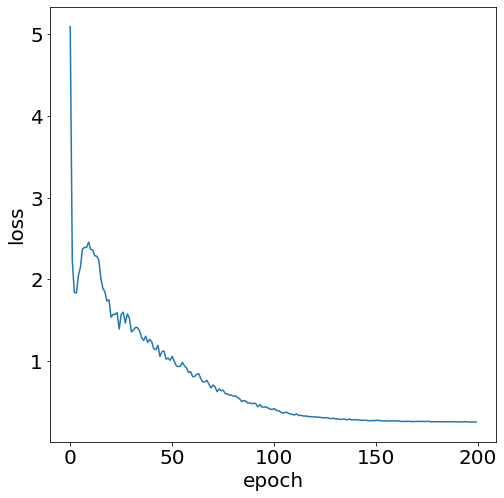

In [48]:
fig = pl.figure(figsize=(8,8))
_ = pl.plot(lloss)
pl.xlabel('epoch')
pl.ylabel('loss')
pl.savefig('./figs/gama_loss_uiz_to_class.png')

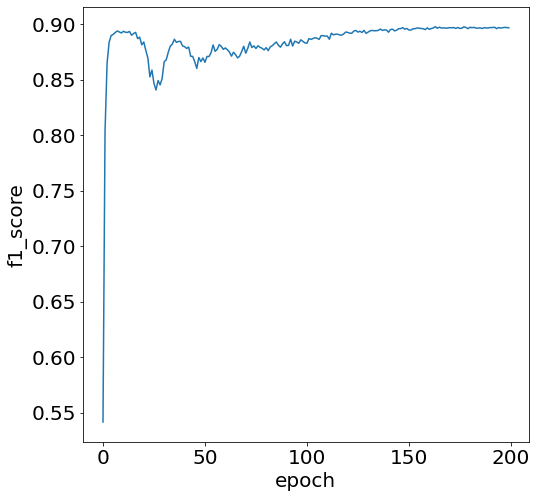

In [49]:
fig = pl.figure(figsize=(8,8))
_ = pl.plot(lf1)
pl.xlabel('epoch')
pl.ylabel('f1_score')
pl.savefig('./figs/gama_f1_uiz_to_class.png')

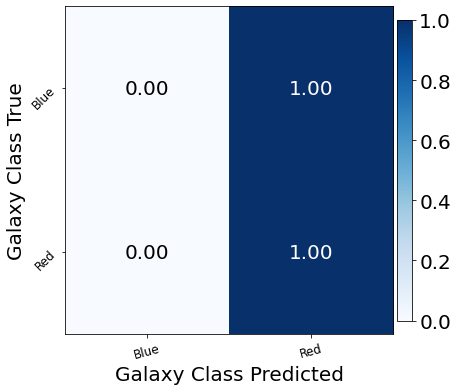

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = ['Blue','Red']
#------------ Confusion Matrix
cm = confusion_matrix(np.array(data.y[data.test_mask].cpu().data), np.array(pred[data.test_mask].cpu().data))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig= pl.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(cm, interpolation='nearest', cmap=pl.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.79)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Galaxy Class Predicted",size=20)
ax.set_ylabel("Galaxy Class True",size=20)
# ax.set_ylim(4-0.5, -0.5)

pl.setp(ax.get_xticklabels(), rotation=15, size=12)
pl.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")
        
pl.show()